In [2]:
%load_ext jupyter_black

In [1]:
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [5]:
one_file = glob("/workspaces/griblib/hrrr/*")[0]
# beacuse of the high quantity of level dims inside the hrrr data the filter_by keys argument must be passed
levels = [
    {"typeOfLevel": "hybrid"},
    {"typeOfLevel": "depthBelowLandLayer"},
    {"typeOfLevel": "atmosphere"},
    {"typeOfLevel": "cloudTop"},
    {"typeOfLevel": "surface"},
    {"typeOfLevel": "heightAboveGround"},
    {"typeOfLevel": "isothermal"},
    {"typeOfLevel": "pressureFromGroundLayer"},
    {"typeOfLevel": "sigmaLayer"},
    {"typeOfLevel": "meanSea"},
    {"typeOfLevel": "isobaricInhPa"},
    {"typeOfLevel": "heightAboveGroundLayer"},
    {"typeOfLevel": "sigma"},
    {"typeOfLevel": "atmosphereSingleLayer", "stepType": "max"},
    {"typeOfLevel": "atmosphereSingleLayer", "stepType": "instant"},
    {"typeOfLevel": "depthBelowLand"},
    {"typeOfLevel": "isobaricLayer"},
    {"typeOfLevel": "lowCloudLayer"},
    {"typeOfLevel": "middleCloudLayer"},
    {"typeOfLevel": "highCloudLayer"},
    {"typeOfLevel": "cloudCeiling"},
    {"typeOfLevel": "cloudBase"},
    {"typeOfLevel": "nominalTop"},
    {"typeOfLevel": "isothermZero"},
    {"typeOfLevel": "highestTroposphericFreezing"},
    {"typeOfLevel": "adiabaticCondensation"},
    {"typeOfLevel": "equilibrium"},
    {"typeOfLevel": "unknown"},
]

ds: xr.Dataset = xr.open_dataset(one_file, engine="cfgrib", filter_by_keys={"typeOfLevel": "atmosphere"})
ds

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    atmosphere  float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    refc        (y, x) float32 ...
    veril       (y, x) float32 ...
    hail        (y, x) float32 ...
    ltng        (y, x) float32 ...
    tcc         (y, x) float32 ...
    unknown     (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-06-24T16:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
import pandas as pd
# in most cases setting the valid_time , latitude , longitude makes the most sense
def normalize_index(df: pd.DataFrame) -> pd.DataFrame:
    df["valid_time"] = df.time + df.step
    return df.drop(["time", "step"], axis=1).set_index(["valid_time", "latitude", "longitude"])

# using the pipe method keeps
ds.to_dataframe().pipe(normalize_index)

atmosphere  refc  veril  hail  ltng   tcc  \
valid_time latitude  longitude                                               
2022-06-17 21.138123 237.280472         0.0 -10.0    0.0   0.0   0.0  44.0   
           21.145110 237.307139         0.0 -10.0    0.0   0.0   0.0  45.0   
           21.152090 237.333810         0.0 -10.0    0.0   0.0   0.0  45.0   
           21.159063 237.360485         0.0 -10.0    0.0   0.0   0.0  45.0   
           21.166029 237.387165         0.0 -10.0    0.0   0.0   0.0  45.0   
...                                     ...   ...    ...   ...   ...   ...   
           47.883306 298.936520         0.0 -10.0    0.0   0.0   0.0   4.0   
           47.873043 298.973110         0.0 -10.0    0.0   0.0   0.0   5.0   
           47.862771 299.009688         0.0 -10.0    0.0   0.0   0.0   6.0   
           47.852488 299.046254         0.0 -10.0    0.0   0.0   0.0   6.0   
           47.842195 299.082807         0.0 -10.0    0.0   0.0   0.0   7.0   

                                   unknown  
valid_time latitude  longitude              
2022-06-17 21.138123 237.280472  35.700001  
           21.145110 237.307139  35.799999  
           21.152090 237.333810  35.900002  
           21.159063 237.360485  36.000000  
           21.166029 237.387165  36.099998  
...                                    ...  
           47.883306 298.936520  33.200001  
           47.873043 298.973110  33.400002  
           47.862771 299.009688  33.599998  
           47.852488 299.046254  33.799999  
           47.842195 299.082807  33.900002  

[1905141 rows x 7 columns]

In [9]:
df = ds.to_dataframe()
df["longitude"] = (df["longitude"] + 180) % 360 - 180
# df.plot()

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

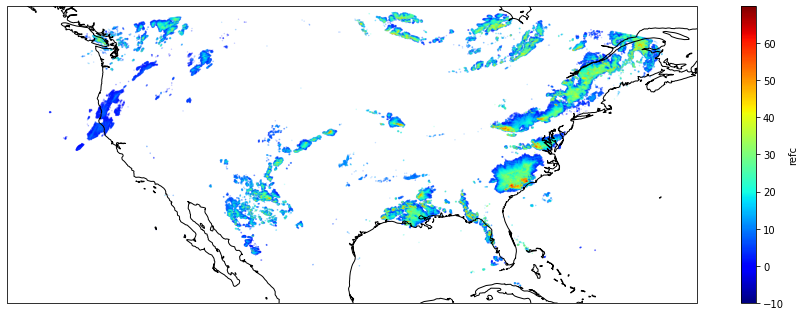

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np


plt.rcParams["axes.grid"] = True

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines("50m")

ax.set_extent(
    [
        *df["longitude"].agg(["min", "max"]),
        *df["latitude"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)

df.plot(
    kind="scatter",
    y="latitude",
    x="longitude",
    c="refc",
    ax=ax,
    alpha=np.where(df["refc"] > 0, 0.2, 0),
    cmap=plt.get_cmap("jet"),
    s=0.25,
    figsize=(16, 12),
)

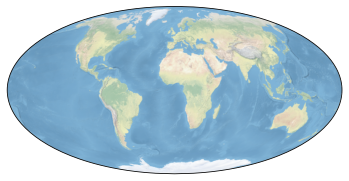

In [3]:
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
plt.show()

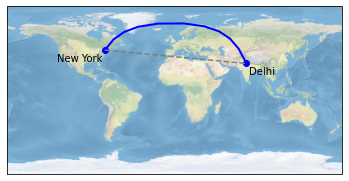

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="blue",
    linewidth=2,
    marker="o",
    transform=ccrs.Geodetic(),
)

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="gray",
    linestyle="--",
    transform=ccrs.PlateCarree(),
)

plt.text(ny_lon - 3, ny_lat - 12, "New York", horizontalalignment="right", transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, "Delhi", horizontalalignment="left", transform=ccrs.Geodetic())

plt.show()